In [300]:
# ---------------------- IMPORTS ----------------------
import os
from os.path import basename
if basename(os.getcwd()) == 'util':
    os.chdir("../")
import config.model
if basename(os.getcwd()) == 'experiment-framework':
    os.chdir("util/")
import numpy  as np
import torch
import pickle
import copy
from collections import OrderedDict
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import torch.utils.data as utils
import torch.nn.functional as F

from activation_plot_code import plot_combination_acts
from activation_plot_code import plot_act_matrix
from activation_plot_code import plot_accuracy_table
from activation_plot_code import plot_ablation_accuracies
from activation_plot_code import update_acts_dicts
from activation_plot_code import get_acts_matrix
from activation_plot_code import get_accuracy_ablation
from activation_plot_code import get_med_and_std
from activation_plot_code import prototype_variance
from activation_plot_code import make_first_upper

# Percentile-related functions
from activation_plot_code import get_percentile_array
from activation_plot_code import get_acts_thresholding

# SELECTIVITY
#(max - avg)/(max + avg)
from activation_plot_code import get_selectivity_array 

#(max - 2nd_max)/(max + 2nd_max)
from activation_plot_code import get_selectivity_array2

#choose task1/task2. max determines which of the num_classes
#    tasks to take min from. elt1 = min. elt2 = max of any combo not in
#    the class being focused on
from activation_plot_code import get_selectivity_array3

#Like get_selectivity_array3, but for specific class
from activation_plot_code import get_selectivity_task

from activation_plot_code import get_selectivity_dicts





In [301]:
# ----------------- ENTER INFO -----------------

#dataset names to choose from: 
#    "left_out_varied_location_mnist", "left_out_colored_mnist, left_out_many_scale_mnist", "left_out_colored_location_mnist"
dataset_name = "left_out_colored_mnist"

#layer name to choose from: 
#    "", "_layer1", "_layer3"
layer = "" 

#model names to choose from:
#    "simple_cnn", "resnet", "resnet_no_pool", "resnet_pretrained",
#    "resnet_pretrained_embeddings", "resnet_early_branching"
model_name = "resnet"

#Select type of state_dict
#    "_color_only", "_shape_only", "_location_only", "" 
state_dict_type = ""

#For plots. Show median/mean/extrema
show_violin_plot_median = True
show_violin_plot_mean = False
show_violin_plot_extrema = True


#Which of the 512 units are displayed in the individual and
#    std/mean/divide plots
individual_neuron_plots_start_index = 9
individual_neuron_plots_end_index = 16

#for activation plots. How many clusters
num_clusters = 20

#Keep_pct for ablations
if dataset_name == "left_out_colored_mnist":
    keep_ablation = 90
    keep_ablation_string = '0.9'
elif dataset_name in ["left_out_varied_location_mnist","left_out_many_scale_mnist",'left_out_colored_location_mnist']:
    keep_ablation = 88
    keep_ablation_string = '0.8888888888888888'
    if dataset_name in ["left_out_many_scale_mnist",'left_out_colored_location_mnist']:
        keep_ablation_string = '8'

#can change keep_pct to get activation plots for different % seen combos

#for left_out_colored_mnist, choices are:
#    .1,.2,.3,.4,.5,.6,.7,.8,.9
if dataset_name == "left_out_colored_mnist":
    keep_pct = 0.9

#for left_out_varied_location_mnist and left_out_many_scale_mnist, choices are:
#    0.1111111111111111,0.2222222222222222,0.3333333333333333,
#    0.4444444444444444,0.5555555555555556,0.6666666666666666,
#    0.7777777777777778,0.8888888888888888
elif dataset_name in ["left_out_varied_location_mnist","left_out_many_scale_mnist",'left_out_colored_location_mnist']:
    keep_pct = 0.8888888888888888
    

#The top x percent (out of 100) to set threshold. 
#for example, setting to 1 means the threshold will 
#be in the top 1% of activation values (99th percentile)
percentile_theshold = 10

#For plots that are applicable, use thresholding instead of just taking
#raw avg firing rate
use_thresholding = False

#Choose True if want to save plots to pdf
save = False

keep_pct_string = str(int(100*keep_pct))
plot_path = act_matrix_path = "../analysis/analysis_plots/" + model_name + "_plots/" + dataset_name + state_dict_type
if dataset_name == "left_out_colored_location_mnist":
    num_tasks = 3
else:
    num_tasks = 2
    
    
if model_name == "resnet_early_branching":
    branching = True
else:
    branching = False
    
    

In [302]:
# ----------------- LOAD DATA -----------------
if dataset_name == "left_out_colored_mnist":
    num_classes = 10
elif dataset_name in ["left_out_varied_location_mnist","left_out_many_scale_mnist","left_out_colored_location_mnist"]:
    num_classes = 9
    
#data_type = ""
file_path = "../analysis/"+model_name+"/activations_data/"+dataset_name+state_dict_type+"/"
filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), state_dict_type)
with open(file_path + filename,'rb') as f:
    activations_dict = pickle.load(f)

In [303]:
# percentile_array = get_percentile_array(activations_dict, percentile_theshold)
# #print(percentile_array)
# threshold_acts_dict = get_acts_thresholding(activations_dict, percentile_array)


In [314]:
# ---------- POPULATE MATRICES/DICTS FOR PLOTTING ----------
combinations = [k for k in activations_dict]

sort_by_task2 = False

if sort_by_task2 and num_tasks == 2:
    combinations.sort(key = lambda x: (x[1],x[0]))
else:
    combinations.sort()

task1_classes = [k for k in range(num_classes)]
task2_classes = [k for k in range(num_classes)]

num_neurons = activations_dict[[k for k in activations_dict][0]].shape[1]
if num_tasks == 2:
    neuron_combinations_mat = np.zeros((num_neurons, num_classes, num_classes))
elif num_tasks == 3:
    neuron_combinations_mat = np.zeros((num_neurons, num_classes, num_classes, num_classes))
threshold_combinations_mat = np.zeros((num_neurons, num_classes, num_classes))

acts_mat = np.zeros((len(combinations),num_neurons))
threshold_acts_mat = np.zeros((len(combinations),num_neurons))

avg_acts_dict = {}
task1_acts_dict = {}
task2_acts_dict = {}
task3_acts_dict = {}

for idx,k in enumerate(combinations):
    avg_acts_dict[k] = np.mean(activations_dict[k],axis=0)
    if num_tasks == 2:
        neuron_combinations_mat[:,k[0],k[1]] = copy.deepcopy(avg_acts_dict[k]) 
        acts_mat[idx] = copy.deepcopy(avg_acts_dict[k])
    elif num_tasks == 3:
        neuron_combinations_mat[:,k[0],k[1],k[2]] = copy.deepcopy(avg_acts_dict[k])
        acts_mat[idx] = copy.deepcopy(avg_acts_dict[k])
    
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_acts_mat = acts_mat / np.max(acts_mat,axis=0)
    normalized_acts_mat = normalized_acts_mat[:,~np.isnan(normalized_acts_mat).any(axis=0)]
    

short_names = {'task1':'shape','left_out_colored_mnist':'shape/color',
               'left_out_varied_location_mnist':'shape/position','_layer1':'layer1',
               '_layer3':'layer3','':'final layer'}

if dataset_name == "left_out_colored_mnist":
    short_names['task2'] = 'color'
elif dataset_name == 'left_out_varied_location_mnist':
    short_names['task2'] = 'position'
elif dataset_name == 'left_out_many_scale_mnist':
    short_names['task2'] = 'scale'
elif dataset_name == 'left_out_colored_location_mnist':
    short_names['task2'] = 'color'
    short_names['task3'] = 'location'
    


<br><b>Individual Neuron Activation Plots</b> $x$-axis: Digit classification, $y$-axis: Color classification

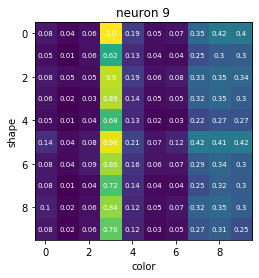

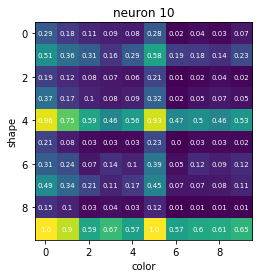

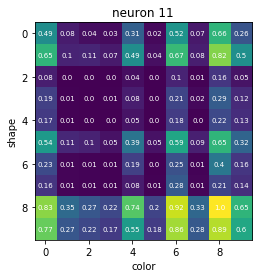

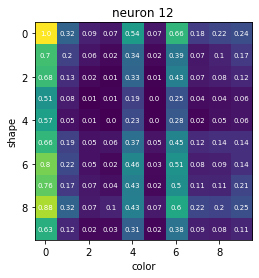

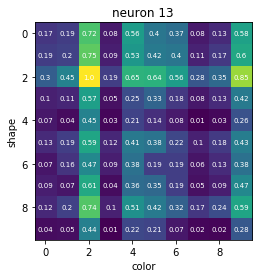

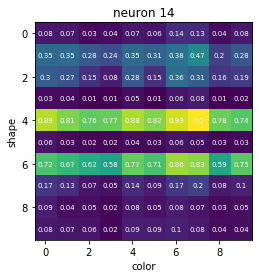

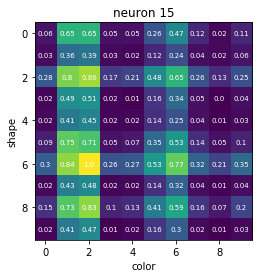

In [315]:
# use_thresholding = use_thresholding
# if use_thresholding:
#     input_mat = threshold_combinations_mat
# else:
#     input_mat = neuron_combinations_mat
input_mat = neuron_combinations_mat

combination_acts_path = plot_path + "/individual_neuron_activations"
if not os.path.exists(combination_acts_path):
    os.makedirs(combination_acts_path)

if num_tasks == 2:
    plot_combination_acts(input_mat,
                          individual_neuron_plots_start_index,
                          individual_neuron_plots_end_index,
                          normalize="individual",
                          num_classes=num_classes,
                          plot_single_column=True,
                          plot_size=4,
                          dataset_name=dataset_name,
                         save=save,
                         save_path = combination_acts_path)





<br><b>Full Activation Plot</b> $y$-axis: target (digit,color), $x$-axis: neuron/cluster

In [316]:
# print(normalized_acts_mat.shape)
# idxs = selectivity_dicts2['_layer1']['task_label'][88] == 0.0
# idxs2 = selectivity_dicts2['_layer1']['task_label'][88] == 1.0
# #print(normalized_acts_mat[:,selectivity_dicts2['_layer1']['task_label'][kp] == 0.0])
# print(selectivity_dicts2['_layer1']['task1'][88][idxs])
# print(selectivity_dicts2['_layer1']['task2'][88][idxs2])
# print()
# print(selectivity_dicts2['_layer1']['task2'][88])


Sort order: task1, task2


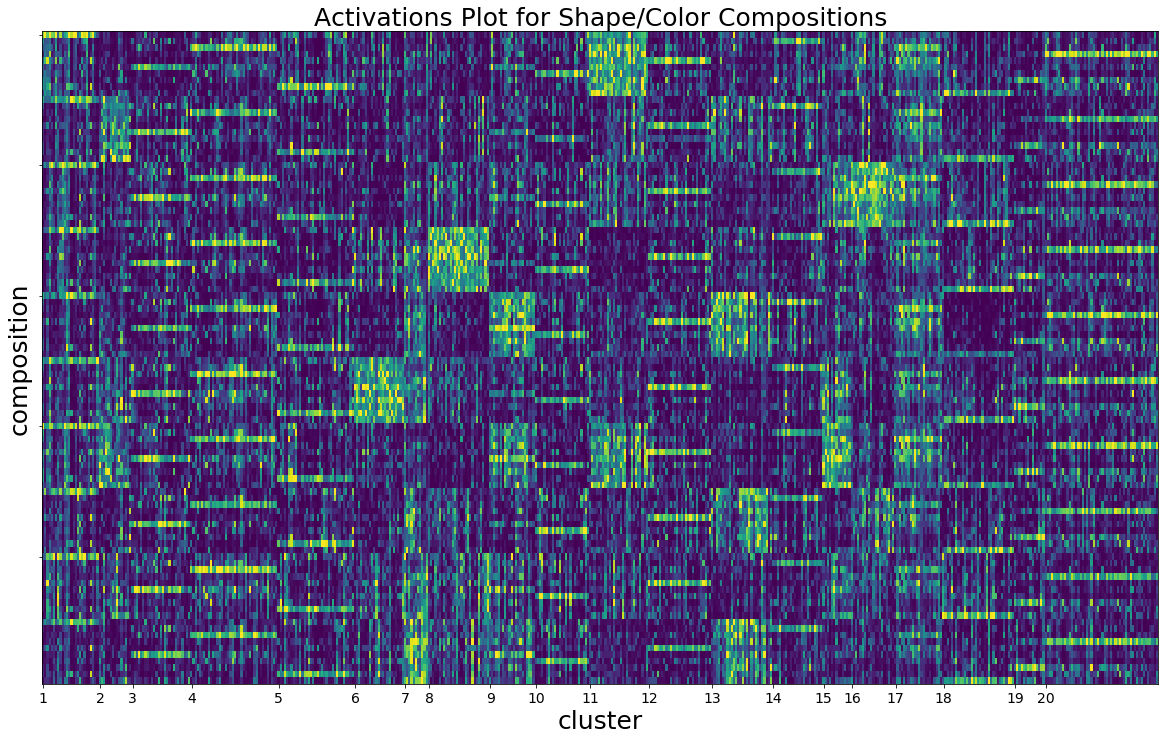

In [317]:
if sort_by_task2:
    print("Sort order: task2, task1")
else:
    print("Sort order: task1, task2")
if use_thresholding:
    input_mat = normalized_threshold_acts_mat
else:
    input_mat = normalized_acts_mat#[:,selectivity_dicts2['_layer1']['task_label'][88] == 0.0]
  
input_mat = np.array(input_mat)

    
act_matrix_path = plot_path + "/full_activations"

if not os.path.exists(act_matrix_path):
    os.makedirs(act_matrix_path)
act_matrix_path += "/" + keep_pct_string + ".pdf"

plot_act_matrix(act_matrix=input_mat, combinations_list=combinations,
                n_clusters=num_clusters,title_dataset=short_names['task2'],
               save=save,
               save_path = act_matrix_path)



In [308]:
# ----------- LOAD DATA FOR SELECTIVITY PLOTS --------------
if dataset_name == "left_out_colored_mnist":
    num_classes = 10
    keep_pct_values = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
else:
    num_classes = 9
    keep_pct_values = [.11,.22,.33,.44,.55,.66,.77,.88]

holdout_acts_dict = {}

for keep_pct in keep_pct_values:
    file_path = "../analysis/"+model_name+"/activations_data/"+dataset_name+state_dict_type+"/"
    filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), state_dict_type)
    with open(file_path + filename,'rb') as f:
        holdout_acts_dict[int(100*keep_pct)] = pickle.load(f)

        
acts_dict_list = []
if model_name == "resnet":
    layer_list = ['_layer1','_layer3','']
else:
    layer_list = ['']

for layer in layer_list:
    holdout_acts_dict_all_layers = {}
    for keep_pct in keep_pct_values:
        file_path = "../analysis/"+model_name+"/activations_data/"+dataset_name+state_dict_type+"/"
        filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), state_dict_type)
        with open(file_path + filename,'rb') as f:
            holdout_acts_dict_all_layers[int(100*keep_pct)] = pickle.load(f)

    acts_dict_list.append(holdout_acts_dict_all_layers)
        
selectivity_dicts = get_selectivity_dicts(acts_dict_list,
                                          layer_list,keep_pct_values,
                                         combinations,num_classes)

num_neurons = holdout_acts_dict[int(100*keep_pct_values[0])][combinations[0]].shape[1]


In [309]:
def get_selectivity_array_relaxed(acts_dict, choice_array, task_idx=0, num_neurons=512, num_classes=10):
    max_acts = np.zeros(num_neurons)
    second_max_acts = np.zeros(num_neurons)
    
    min_acts = np.ones(num_neurons)*9999
    second_min_acts = np.ones(num_neurons)*9999
    
    max_lookup = np.zeros(num_neurons)
    second_max_lookup = np.zeros(num_neurons)
    
    selectivity_vals = np.zeros(num_neurons)

    for idx, k in enumerate(choice_array):
        max_lookup[acts_dict[k] > max_acts] = k[task_idx]
        max_acts = np.maximum(max_acts, np.array(acts_dict[k]))

    for k in choice_array:
        update_idx = max_lookup == k[task_idx]
        min_acts[update_idx] = np.minimum(min_acts[update_idx], copy.deepcopy(acts_dict[k][update_idx]))

        second_update_idx = max_lookup != k[task_idx]
        second_max_lookup[second_update_idx][acts_dict[k][second_update_idx] > second_max_acts[second_update_idx]] = k[task_idx]
        second_max_acts[second_update_idx] = np.maximum(second_max_acts[second_update_idx], np.array(acts_dict[k][second_update_idx]))
        
    for k in choice_array:
        update_idx = second_max_lookup == k[task_idx]
        second_min_acts[update_idx] = np.minimum(second_min_acts[update_idx], np.array(acts_dict[k][update_idx]))
    
    for k in choice_array:
        statement1 = max_lookup != k[task_idx]
        statement2 = second_max_lookup != k[task_idx]
        update_idx = statement1 & statement2
        comparison = copy.deepcopy(acts_dict[k][update_idx])
        selectivity_vals[update_idx] = np.maximum(selectivity_vals[update_idx], comparison)

    with np.errstate(divide='ignore',invalid='ignore'):
        min_acts = np.maximum(min_acts, second_min_acts)
        selectivity_vals = (min_acts - selectivity_vals)/(min_acts + selectivity_vals)
        selectivity_vals[np.isnan(selectivity_vals)] = 0

    return selectivity_vals


def get_selectivity_array_relaxed2(acts_dict, choice_array, task_idx=0, num_neurons=512, num_classes=10):
    max_acts = np.zeros(num_neurons)    
    min_acts = np.ones(num_neurons)*9999    
    max_lookup = np.zeros(num_neurons)
    
    selectivity_vals = np.zeros(num_neurons)

    for idx, k in enumerate(choice_array):
        max_lookup[acts_dict[k] > max_acts] = k[task_idx]
        max_acts = np.maximum(max_acts, np.array(acts_dict[k]))

    for k in choice_array:
        update_idx = max_lookup == k[task_idx]
        min_acts[update_idx] = np.minimum(min_acts[update_idx], copy.deepcopy(acts_dict[k][update_idx]))


    num_combos_over = np.zeros(num_neurons)
    for k in choice_array:
        #criteria: increment value in num_combos_over by 1 for every combo with fire rate lower than min of selective attribute
        statement1 = max_lookup != k[task_idx]
        statement2 = min_acts > np.array(acts_dict[k])
        update_idx = statement1 & statement2
        if len(update_idx) > 0:
            num_combos_over[update_idx] += 1
            
    if len(choice_array[0]) == 2:
        num_combos_over = num_combos_over/(num_classes**2-num_classes)
    elif len(choice_array[0]) == 3:
        num_combos_over = num_combos_over/(num_classes**3-num_classes**2)
        
    return num_combos_over

#selectivity = (avg_in - avg_out)/(avg_in + avg_out)
def get_selectivity_array_relaxed3(acts_dict, choice_array, task_idx=0, num_neurons=512, num_classes=10):
    max_acts = np.zeros(num_neurons)
    avg_inside = np.zeros(num_neurons)
    avg_outside = np.zeros(num_neurons)
    med_in = None
    max_lookup = np.zeros(num_neurons)
    smax = np.zeros(num_neurons)
    
    selectivity_vals = np.zeros(num_neurons)
    
    for idx, k in enumerate(choice_array):
        max_lookup[acts_dict[k] > max_acts] = k[task_idx]
        max_acts = np.maximum(max_acts, np.array(acts_dict[k]))
    '''
    for idx, k in enumerate(choice_array):
        update_idx_inside = max_lookup == k[task_idx]
        update_idx_outside = max_lookup != k[task_idx]
        avg_inside[update_idx_inside] += acts_dict[k][update_idx_inside]
        avg_outside[update_idx_outside] += acts_dict[k][update_idx_outside]
    avg_inside /= num_classes
    avg_outside /= len(choice_array)-num_classes
    
    selectivity_vals = (avg_inside - avg_outside)/(avg_inside + avg_outside)
    '''
    for idx, k in enumerate(choice_array):
        update_idx = max_lookup != k[task_idx]
        smax[update_idx] = np.maximum(smax[update_idx],acts_dict[k][update_idx])
        
        
    med_list = []
    for i in range(num_neurons):
        med_list.append([])
     
    for idx, k in enumerate(choice_array):
        
        update_idx_inside = max_lookup == k[task_idx]
        update_idx_outside = max_lookup != k[task_idx]
        avg_outside[update_idx_outside] += acts_dict[k][update_idx_outside]
        
        for i,val in enumerate(update_idx_inside):
            if val:
                med_list[i].append(acts_dict[k][i])
    med_list = np.array(med_list)
            
#         med_in[,update_idx_inside] = acts_dict[k][update_idx_inside]
        
    med_in = np.median(med_list,axis=1)
    avg_outside /= len(choice_array)-num_classes

    
        
    selectivity_vals = (med_in - avg_outside)/(med_in + avg_outside)
    #selectivity_vals = (med_in - smax)/(med_in + smax)
    return selectivity_vals
    
        

def get_selectivity_dicts2(acts_dict_list, layer_names, keep_pcts, combinations, num_classes=10, num_tasks=2):
    num_neurons_list = []
    for acts_dict in acts_dict_list:
        num_neurons_list.append(acts_dict[int(100*keep_pcts[0])][combinations[0]].shape[1])

    selectivity_dicts = {}
    tasks = ['combos','task1','task2','task3','task1_individual','task2_individual','task3_individual','task_label']
    for layer_idx,layer in enumerate(layer_names):
        selectivity_dicts[layer] = {}
        for task in tasks:
            selectivity_dicts[layer][task] = {}

        combo_acts_dict = {}
        task1_acts_dict = {}
        task2_acts_dict = {}

        for keep_pct in keep_pcts:
            keep_pct = int(100 * keep_pct)
            combo_acts_dict[keep_pct] = {}
            task1_acts_dict[keep_pct] = {}
            task2_acts_dict[keep_pct] = {}

            update_acts_dicts(combinations[:],acts_dict_list[layer_idx][keep_pct],
                              combo_acts_dict[keep_pct],
                              task1_acts_dict[keep_pct],
                              task2_acts_dict[keep_pct],
                              num_neurons=num_neurons_list[layer_idx])
            
            
            selectivity_dicts[layer]['combos'][keep_pct] = get_selectivity_array2(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons_list[layer_idx])
            selectivity_dicts[layer]['task1'][keep_pct] = get_selectivity_array_relaxed3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons_list[layer_idx], task_idx=0,num_classes=num_classes)
            selectivity_dicts[layer]['task2'][keep_pct] = get_selectivity_array_relaxed3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons_list[layer_idx], task_idx=1,num_classes=num_classes)
            if num_tasks == 3:
                selectivity_dicts[layer]['task3'][keep_pct] = get_selectivity_array_relaxed3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons_list[layer_idx], task_idx=2, num_classes=num_classes)
                selectivity_dicts[layer]['task3_individual'][keep_pct] = {}
            selectivity_dicts[layer]['task1_individual'][keep_pct] = {}
            selectivity_dicts[layer]['task2_individual'][keep_pct] = {}
        
            
            #get task label
            selectivity1 = np.array(selectivity_dicts[layer]['task1'][keep_pct])
            selectivity2 = np.array(selectivity_dicts[layer]['task2'][keep_pct])
            task2_idx = selectivity1 < selectivity2
            if num_tasks == 3:
                selectivity3 = np.array(selectivity_dicts[layer]['task3'][keep_pct])
                task2_idx = (selectivity1 < selectivity2) & (selectivity2 > selectivity3)
                task3_idx = (selectivity3 > selectivity2) & (selectivity3 > selectivity1)
        
                
            
            selectivity_dicts[layer]['task_label'][keep_pct] = np.zeros(selectivity1.shape)
            selectivity_dicts[layer]['task_label'][keep_pct][task2_idx] = 1.0
            if num_tasks == 3:
                selectivity_dicts[layer]['task_label'][keep_pct][task3_idx] = 2.0

            #taskn_individual represents selectivity to a manually assigned attribute of task n
            for c in range(num_classes):
                if c not in selectivity_dicts[layer]['task1_individual'][keep_pct]:
                    selectivity_dicts[layer]['task1_individual'][keep_pct][c] = get_selectivity_task(combo_acts_dict[keep_pct],combinations[:],class_num=c,task_idx=0,num_neurons=num_neurons_list[layer_idx])
                    selectivity_dicts[layer]['task2_individual'][keep_pct][c] = get_selectivity_task(combo_acts_dict[keep_pct],combinations[:],class_num=c,task_idx=1,num_neurons=num_neurons_list[layer_idx])
                    if num_tasks == 3:
                        selectivity_dicts[layer]['task3_individual'][keep_pct][c] = get_selectivity_task(combo_acts_dict[keep_pct],combinations[:],class_num=c,task_idx=2,num_neurons=num_neurons_list[layer_idx])

    return selectivity_dicts

selectivity_dicts2 = get_selectivity_dicts2(acts_dict_list,
                                          layer_list,keep_pct_values,
                                          combinations,num_classes,
                                           num_tasks=num_tasks)




In [310]:
#print(num_tasks)
#print(selectivity_dicts2['']['task1'][88])

In [311]:



# combo_acts_dict = {}
# task1_acts_dict = {}
# task2_acts_dict = {}

# combo_thres_dict = {}
# task1_thres_dict = {}
# task2_thres_dict = {}

# #(Max-Second_max)/(Max+Second_max)
# selectivity2_combos = {}
# selectivity2_combos_thres = {}

# #(Min_in_class - Max_elsewhere)/(Min_in_class + Max_elsewhere)
# selectivity3_task1 = {}
# selectivity3_task2 = {}
# selectivity3_task1_thres = {}
# selectivity3_task2_thres = {}


# #Prototype of variance (max - min_in_group)/(max + min_in_group)
# variance_task1 = {}
# variance_task2 = {}

# variance_task1_thres = {}
# variance_task2_thres = {}


# #For calculating top n selective neurons per class later
# #Uses same as selectivity3 but in plot function you can specify task_idx AND class
# selectivity_task1 = []
# selectivity_task2 = []
# selectivity_task1_thres = []
# selectivity_task2_thres = []
# for i in range(num_classes):
#     selectivity_task1.append({})
#     selectivity_task2.append({})
#     selectivity_task1_thres.append({})
#     selectivity_task2_thres.append({})


# for keep_pct in keep_pct_values:
#     keep_pct = int(100 * keep_pct)

#     combo_acts_dict[keep_pct] = {}
#     task1_acts_dict[keep_pct] = {}
#     task2_acts_dict[keep_pct] = {}
    
#     combo_thres_dict[keep_pct] = {}
#     task1_thres_dict[keep_pct] = {}
#     task2_thres_dict[keep_pct] = {}
    
#     #For avg firing rate
#     update_acts_dicts(combinations[:], holdout_acts_dict[keep_pct],
#                       combo_acts_dict[keep_pct], task1_acts_dict[keep_pct],
#                       task2_acts_dict[keep_pct], num_neurons=num_neurons)
    
#     #For thresholding
#     update_acts_dicts(combinations[:], holdout_acts_dict[keep_pct],
#                      combo_thres_dict[keep_pct], task1_thres_dict[keep_pct],
#                      task2_thres_dict[keep_pct], num_neurons=num_neurons,
#                      use_threshold=True, percentile_threshold=percentile_theshold)
    
#     #SELECTIVITY
#     selectivity2_combos[keep_pct] = get_selectivity_array2(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons)
#     selectivity3_task1[keep_pct] = get_selectivity_array3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=0)
#     selectivity3_task2[keep_pct] = get_selectivity_array3(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=1)
    
#     selectivity2_combos_thres[keep_pct] = get_selectivity_array2(combo_thres_dict[keep_pct], combinations[:], num_neurons=num_neurons)
#     selectivity3_task1_thres[keep_pct] = get_selectivity_array3(combo_thres_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=0)
#     selectivity3_task2_thres[keep_pct] = get_selectivity_array3(combo_thres_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=1)
    
#     #VARIANCE?
#     variance_task1[keep_pct] = prototype_variance(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=0)
#     variance_task2[keep_pct] = prototype_variance(combo_acts_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=1)
    
#     variance_task1_thres[keep_pct] = prototype_variance(combo_thres_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=0)
#     variance_task2_thres[keep_pct] = prototype_variance(combo_thres_dict[keep_pct], combinations[:], num_neurons=num_neurons, task_idx=1)
    
    
#     for i in range(num_classes):
#         selectivity_task1[i][keep_pct] =  get_selectivity_task(combo_acts_dict[keep_pct], combinations[:], class_num=i, task_idx=0, num_neurons=num_neurons)
#         selectivity_task2[i][keep_pct] =  get_selectivity_task(combo_acts_dict[keep_pct], combinations[:], class_num=i, task_idx=1, num_neurons=num_neurons)
        
#         selectivity_task1_thres[i][keep_pct] =  get_selectivity_task(combo_thres_dict[keep_pct], combinations[:], class_num=i, task_idx=0, num_neurons=num_neurons)
#         selectivity_task2_thres[i][keep_pct] =  get_selectivity_task(combo_thres_dict[keep_pct], combinations[:], class_num=i, task_idx=1, num_neurons=num_neurons)
    

<br><b>Selectivity Plots</b>

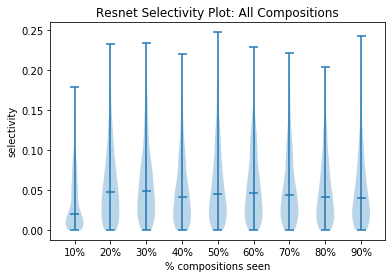

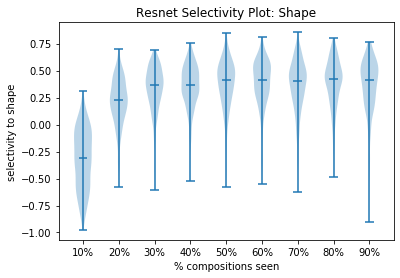

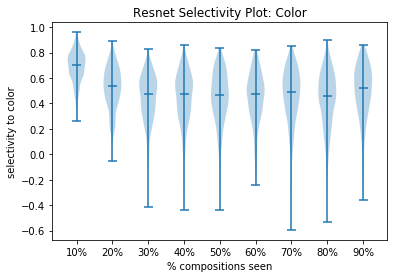

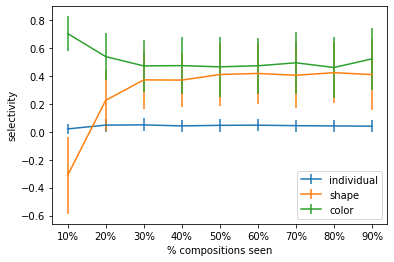

In [312]:
select_path = plot_path + "/selectivity_plots/"
if not os.path.exists(select_path):
    os.makedirs(select_path)


import warnings
warnings.filterwarnings("ignore")
import matplotlib
from matplotlib import pyplot as plt
if not use_thresholding:
    select1 = selectivity_dicts2['']['combos']#selectivity2_combos
    select2 = selectivity_dicts2['']['task1']#selectivity3_task1
    select3 = selectivity_dicts2['']['task2']#selectivity3_task2
    if num_tasks ==3:
        select4 = selectivity_dicts2['']['task3']


#print(selectivity_dicts2['']['task_label'])
y1_violin = [select1[int(100*kpt)] for kpt in keep_pct_values]
y2_violin = []
y3_violin = []
y4_violin = []
for kpt in keep_pct_values:
    add_y2 = select2[int(100*kpt)]#[selectivity_dicts2['']['task_label'][int(100*kpt)] == 0.0]
    add_y3 = select3[int(100*kpt)]#[selectivity_dicts2['']['task_label'][int(100*kpt)] == 1.0]
    if len(add_y2) == 0:
        #np.array([float('inf')]) #select2[int(100*kpt)]
        add_y2 = np.array([float('inf')])
    if len(add_y3) == 0:
        #np.array([float('inf')]) #select3[int(100*kpt)]
        add_y3 = np.array([float('inf')])
    y2_violin.append(add_y2)
    y3_violin.append(add_y3)
    
    if num_tasks == 3:
        add_y4 = select4[int(100*kpt)]#[selectivity_dicts2['']['task_label'][int(100*kpt)] == 2.0]
        if len(add_y4) == 0:
            #np.array([float('inf')]) select4[int(100*kpt)]
            add_y4 = np.array([float('inf')])
        y4_violin.append(add_y4)
'''
y2_violin = [select2[int(100*kpt)] for kpt in keep_pct_values]
y3_violin = [select3[int(100*kpt)] for kpt in keep_pct_values]
'''
xlabs = [str(int(100*kpt)) + '%' for kpt in keep_pct_values]

showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema
save=save

fig, ax = plt.subplots()
plt.xlabel("% compositions seen")
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel("selectivity")
plt.title(make_first_upper(model_name) + " Selectivity Plot: All Compositions")
plt.violinplot(y1_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(select_path + make_first_upper(model_name)+"_selectivity_compositions.pdf")
plt.show()

fig, ax = plt.subplots()
plt.xlabel("% compositions seen")
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel("selectivity to shape")
plt.title(make_first_upper(model_name) + " Selectivity Plot: "+make_first_upper(short_names['task1'] + ""))
plt.violinplot(y2_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(select_path + make_first_upper(model_name)+"_selectivity_"+short_names['task1']+".pdf")
plt.show()

fig, ax = plt.subplots()
plt.xlabel("% compositions seen")
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel("selectivity to "+short_names['task2'])
plt.title(make_first_upper(model_name) + " Selectivity Plot: "+make_first_upper(short_names['task2'] + ""))
plt.violinplot(y3_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(select_path + make_first_upper(model_name)+"_selectivity_"+short_names['task2']+".pdf")
plt.show()


if num_tasks == 3:
    fig, ax = plt.subplots()
    plt.xlabel("% compositions seen")
    ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
    ax.set_xticklabels(xlabs)
    plt.ylabel("selectivity to "+short_names['task3'])
    plt.title(make_first_upper(model_name) + " Selectivity Plot: "+make_first_upper(short_names['task3'] + ""))
    plt.violinplot(y4_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
    if save:
        plt.savefig(select_path + make_first_upper(model_name)+"_selectivity_"+short_names['task3']+".pdf")
    plt.show()

y1 = [np.median(select1[int(100*kpt)]) for kpt in keep_pct_values]
y1_err = [np.std(select1[int(100*kpt)]) for kpt in keep_pct_values]

y2 = [np.median(select2[int(100*kpt)]) for kpt in keep_pct_values]
y2_err = [np.std(select2[int(100*kpt)]) for kpt in keep_pct_values]

y3 = [np.median(select3[int(100*kpt)]) for kpt in keep_pct_values]
y3_err = [np.std(select3[int(100*kpt)]) for kpt in keep_pct_values]

if num_tasks==3:
    y4 = [np.median(select4[int(100*kpt)]) for kpt in keep_pct_values]
    y4_err = [np.std(select4[int(100*kpt)]) for kpt in keep_pct_values]

xlabs = [str(int(100*kpt)) + '%' for kpt in keep_pct_values]

fig, ax = plt.subplots()
plt.xlabel("% compositions seen")
#ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
#ax.set_xticklabels(xlabs)
plt.ylabel("selectivity")
#plt.title(make_first_upper(model_name) + " Selectivity Plot: All Compositions")
plt.errorbar(x = xlabs,#[int(100*kpt) for kpt in keep_pct_values],
             y = y1,
             yerr = y1_err,label='individual')

plt.errorbar(x = xlabs,
             y = y2,
             yerr = y2_err,label=short_names['task1'])

plt.errorbar(x = xlabs,
             y = y3,
             yerr = y3_err,label=short_names['task2'])

if num_tasks == 3:
    plt.errorbar(x = xlabs,
                 y = y4,
                 yerr = y4_err,label=short_names['task3'])
plt.legend()
plt.show()





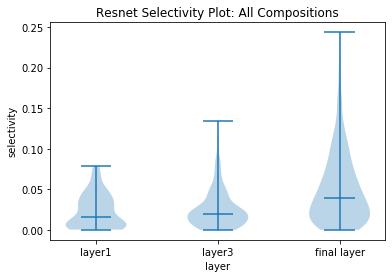

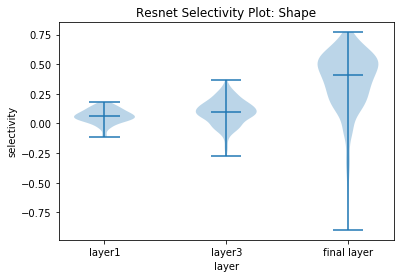

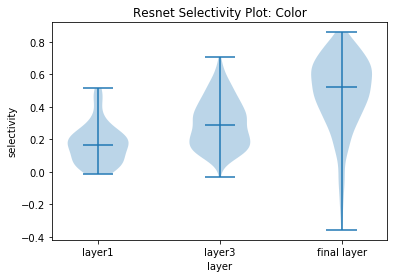

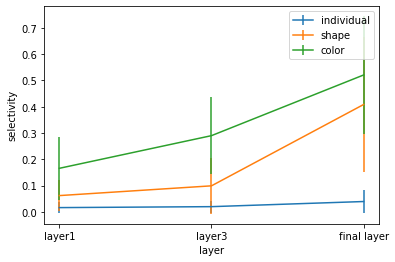

In [313]:

showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema

#Selectivity_dicts -- layer-->task-->keep_pct
if model_name == 'resnet':
    y1_violin = []
    y2_violin = []
    y3_violin = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y1_err = []
    y2_err = []
    y3_err = []
    y4_err = []
    
    y4_violin = []
#     y5_violin = []
#     y6_violin = []
    
    xlabs = []
    xlabs2 = []
    keep_idx = -1
    ls = ['layer1','layer3','final layer']
    for idx,l in enumerate(['_layer1','_layer3','']):
        kp = int(100*keep_pct_values[keep_idx])
        add_y2 = selectivity_dicts2[l]['task1'][kp]#[selectivity_dicts2[l]['task_label'][kp] == 0.0]
        add_y3 = selectivity_dicts2[l]['task2'][kp]#[selectivity_dicts2[l]['task_label'][kp] == 1.0]
        if len(add_y2) == 0:
            add_y2 = np.array([float('inf')])#selectivity_dicts2[l]['task1'][kp]
        if len(add_y3) == 0:
            add_y3 = np.array([float('inf')])#selectivity_dicts2[l]['task2'][kp]
            
        if num_tasks == 3:
            add_y4 = selectivity_dicts2[l]['task3'][kp]#[selectivity_dicts2[l]['task_label'][kp] == 2.0]
            if len(add_y4) == 0:
                add_y4 = np.array([float('inf')])#selectivity_dicts2[l]['task3'][kp]
                
            y4_violin.append(add_y4)
        
        
        y1_violin.append(selectivity_dicts2[l]['combos'][kp])
        y2_violin.append(add_y2)
        y3_violin.append(add_y3)
        
        y1.append(np.median(selectivity_dicts2[l]['combos'][kp]))
        y2.append(np.median(selectivity_dicts2[l]['task1'][kp]))
        y3.append(np.median(selectivity_dicts2[l]['task2'][kp]))
        y1_err.append(np.std(selectivity_dicts2[l]['combos'][kp]))
        y2_err.append(np.std(selectivity_dicts2[l]['task1'][kp]))
        y3_err.append(np.std(selectivity_dicts2[l]['task2'][kp]))
        if num_tasks==3:
            y4.append(np.median(selectivity_dicts2[l]['task3'][kp]))
            y4_err.append(np.std(selectivity_dicts2[l]['task3'][kp]))
        
        xlabs.append(ls[idx])
    
    fig, ax = plt.subplots()
    plt.xlabel("layer")
    ax.set_xticks([r+1 for r in range(3)])
    ax.set_xticklabels(xlabs)
    plt.ylabel("selectivity")
    plt.title(make_first_upper(model_name) + " Selectivity Plot: All Compositions" + "")
    plt.violinplot(y1_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
    if save:
        plt.savefig(select_path + "selectivity_per_layer_all_compositions.pdf")
    plt.show()
    
    fig, ax = plt.subplots()
    plt.xlabel("layer")
    ax.set_xticks([r+1 for r in range(3)])
    ax.set_xticklabels(xlabs)
    plt.ylabel("selectivity")
    plt.title(make_first_upper(model_name) + " Selectivity Plot: "+make_first_upper(short_names['task1'] + ""))
    plt.violinplot(y2_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
    if save:
        plt.savefig(select_path + "selectivity_per_layer_"+short_names['task1']+".pdf")
    plt.show()
    
    fig, ax = plt.subplots()
    plt.xlabel("layer")
    ax.set_xticks([r+1 for r in range(3)])
    ax.set_xticklabels(xlabs)
    plt.ylabel("selectivity")
    plt.title(make_first_upper(model_name) + " Selectivity Plot: "+make_first_upper(short_names['task2'] + ""))
    plt.violinplot(y3_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
    if save:
        plt.savefig(select_path + "selectivity_per_layer_"+short_names['task2']+".pdf")
    plt.show()
    
    
    if num_tasks == 3:
        fig, ax = plt.subplots()
        plt.xlabel("layer")
        ax.set_xticks([r+1 for r in range(3)])
        ax.set_xticklabels(xlabs)
        plt.ylabel("selectivity")
        plt.title(make_first_upper(model_name) + " Selectivity Plot: "+make_first_upper(short_names['task3'] + ""))
        plt.violinplot(y4_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
        if save:
            plt.savefig(select_path + "selectivity_per_layer_"+short_names['task3']+".pdf")
        plt.show()
        
    fig, ax = plt.subplots()
    plt.xlabel("layer")
    plt.ylabel("selectivity")
    plt.errorbar(x = xlabs,#[int(100*kpt) for kpt in keep_pct_values],
             y = y1,
             yerr = y1_err,label='individual')

    plt.errorbar(x = xlabs,
                 y = y2,
                 yerr = y2_err,label=short_names['task1'])

    plt.errorbar(x = xlabs,
                 y = y3,
                 yerr = y3_err,label=short_names['task2'])
    if num_tasks==3:
        plt.errorbar(x = xlabs,
                 y = y3,
                 yerr = y3_err,label=short_names['task3'])
    plt.legend()
    plt.show()


In [128]:
'''
if not use_thresholding:
    variance1 = variance_task1
    variance2 = variance_task2
else:
    variance1 = variance_task1_thres
    variance2 = variance_task2_thres

x = [str(int(100*kpt)) for kpt in keep_pct_values]
y2_violin = [variance1[int(100*kpt)] for kpt in keep_pct_values]
y3_violin = [variance2[int(100*kpt)] for kpt in keep_pct_values]

xlabs = [str(int(100*kpt)) + '%' for kpt in keep_pct_values]
showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema

#plt.figure()
fig, ax = plt.subplots()
plt.xlabel("% combinations seen")
#plt.xticks([r+1 for r in range(len(keep_pct_values))],xlabs)
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel("variance to shape")
plt.title(model_name + " variance plot: shapes")
#plt.errorbar(x, y2, yerr=y2err)
plt.violinplot(y2_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()

#plt.figure()
fig, ax = plt.subplots()
plt.xlabel("% combinations seen")
#plt.xticks([r+1 for r in range(len(keep_pct_values))],xlabs)
ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
ax.set_xticklabels(xlabs)
plt.ylabel(" to ")
plt.title(model_name + " variance plot: ")
#plt.errorbar(x, y3, yerr=y3err)
plt.violinplot(y3_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
plt.show()
'''







'\nif not use_thresholding:\n    variance1 = variance_task1\n    variance2 = variance_task2\nelse:\n    variance1 = variance_task1_thres\n    variance2 = variance_task2_thres\n\nx = [str(int(100*kpt)) for kpt in keep_pct_values]\ny2_violin = [variance1[int(100*kpt)] for kpt in keep_pct_values]\ny3_violin = [variance2[int(100*kpt)] for kpt in keep_pct_values]\n\nxlabs = [str(int(100*kpt)) + \'%\' for kpt in keep_pct_values]\nshowmedians = show_violin_plot_median\nshowmeans = show_violin_plot_mean\nshowextrema = show_violin_plot_extrema\n\n#plt.figure()\nfig, ax = plt.subplots()\nplt.xlabel("% combinations seen")\n#plt.xticks([r+1 for r in range(len(keep_pct_values))],xlabs)\nax.set_xticks([r+1 for r in range(len(keep_pct_values))])\nax.set_xticklabels(xlabs)\nplt.ylabel("variance to shape")\nplt.title(model_name + " variance plot: shapes")\n#plt.errorbar(x, y2, yerr=y2err)\nplt.violinplot(y2_violin, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)\nplt.show()\n\n#p

In [129]:
run_eval = True

In [131]:
if basename(os.getcwd()) == 'experiment-framework':
    os.chdir("util/")
classes = [n for n in range(num_classes)]

if dataset_name in ["left_out_varied_location_mnist","left_out_many_scale_mnist"]:
    keep = keep_ablation
    keep_pct = keep_ablation_string
    num_classes = 9
else:
    keep = keep_ablation
    keep_pct = keep_ablation_string
    num_classes = 10
    
early_stop=10000

columns = [str(n) for n in range(num_classes)]
rows = [str(n) for n in range(num_classes)]
data1 = np.zeros((num_classes,num_classes))
data2 = np.zeros((num_classes,num_classes))
data3 = np.zeros((num_classes,num_classes))
data4 = np.zeros((num_classes,num_classes))
data5 = np.zeros((num_classes,num_classes))
data6 = np.zeros((num_classes,num_classes))

n = 100 #NUMBER OF NEURONS TO ABLATE

if model_name != "simple_cnn":
    if layer == '_layer1':
        n = 64//5
        to_ablate_rnd = np.random.random_integers(0,63,n)
    elif layer == '_layer3':
        n = 256//5
        to_ablate_rnd = np.random.random_integers(0,255,n)
    else:
        to_ablate_rnd = np.random.random_integers(0,511,n)
else:
    to_ablate_rnd = np.random.random_integers(0,499,n)

run = "all"

#Task1
if run_eval and (run == "task1" or run == "all"):
    for c1 in range(num_classes):

        ordered_neurons = np.argsort(selectivity_dicts[layer]['task1_individual'][keep][c1])#selectivity_task1[c1][keep])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        ablated = ordered_neurons[:n]

        print(c1, ablated[:5])
        
        for c2 in range(num_classes):
            targets = [(c2,k) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False,layer_name=layer,only=state_dict_type)
            data1[c1][c2] = acc1
            
            targets = [(k,c2) for k in range(num_classes)]  
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False,layer_name=layer,only=state_dict_type)
            data2[c1][c2] = acc2
            print('---')
            
    d1 = data1
    d2 = data2
    
#task2
if run_eval and (run == "task2" or run == "all"):
    for c1 in range(num_classes):

        ordered_neurons = np.argsort(selectivity_dicts[layer]['task2_individual'][keep][c1])#selectivity_task2[c1][keep])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        ablated = ordered_neurons[:n]

        print(c1)

        for c2 in range(num_classes):
            targets = [(c2,k) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False,layer_name=layer,only=state_dict_type)
            data3[c1][c2] = acc1
            
            targets = [(k,c2) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False,layer_name=layer,only=state_dict_type)
            data4[c1][c2] = acc2
            print('---')

    d3 = data3
    d4 = data4
    
if run_eval and (run == "random" or run == "all"):
    for c1 in range(num_classes):

        ablated = to_ablate_rnd

        print(c1)

        for c2 in range(num_classes):
            targets = [(c2,k) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False,layer_name=layer,only=state_dict_type)
            data5[c1][c2] = acc1
            
            targets = [(k,c2) for k in range(num_classes)]
            acc1, acc2 = get_accuracy_ablation(model_name,dataset_name, keep_pct, ablated_neurons_list=ablated, target_combos=targets, early_stop=early_stop, num_classes=num_classes, verbose=False,layer_name=layer,only=state_dict_type)
            data6[c1][c2] = acc2
            print('---')

    d5 = data5
    d6 = data6
    




    


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. Please call randint(0, 511 + 1) instead


0 [369 464 212 173 200]
RESULTS: 0.7341772151898734 1.0
RESULTS: 0.9269662921348315 1.0
---
RESULTS: 1.0 1.0
RESULTS: 0.9352941176470588 0.9764705882352941
---
RESULTS: 0.8516129032258064 1.0
RESULTS: 0.8972602739726028 1.0
---
RESULTS: 0.9689119170984456 1.0
RESULTS: 0.9171597633136095 1.0
---
RESULTS: 0.9698795180722891 1.0
RESULTS: 0.9226519337016574 1.0
---
RESULTS: 0.9710144927536232 1.0
RESULTS: 0.9753086419753086 1.0
---
RESULTS: 0.9607843137254902 0.9738562091503268
RESULTS: 0.875 1.0
---
RESULTS: 0.9662921348314607 1.0
RESULTS: 0.976878612716763 1.0
---
RESULTS: 0.9120879120879121 1.0
RESULTS: 0.9241379310344827 1.0
---
1 [438 488 329 225 111]
RESULTS: 1.0 1.0
RESULTS: 0.9606741573033708 1.0
---
RESULTS: 0.572972972972973 1.0
RESULTS: 0.8470588235294118 1.0
---
RESULTS: 0.8903225806451613 1.0
RESULTS: 0.952054794520548 1.0
---
RESULTS: 0.9689119170984456 1.0
RESULTS: 0.9408284023668639 1.0
---
RESULTS: 0.9759036144578314 1.0
RESULTS: 0.8839779005524862 1.0
---
RESULTS: 0.97101

KeyboardInterrupt: 

In [42]:
if run_eval:
    print("Ablation of 100 shape selective neurons: Accuracy for shape classes")
    plot_accuracy_table(d1,num_classes=num_classes)

    print("\n\nAblation of 100 shape selective neurons: Accuracy for color classes")
    plot_accuracy_table(d2,num_classes=num_classes)

    print("Ablation of 100 color selective neurons: Accuracy for shape classes")
    plot_accuracy_table(d3,num_classes=num_classes)

    print("\n\nAblation of 100 color selective neurons: Accuracy for color classes")
    plot_accuracy_table(d4,num_classes=num_classes)



In [43]:
if run_eval:
    if keep_ablation < 88:
        keep_val = str(keep_ablation)
    else:
        keep_val = ''
    name = "ablate_{}-test_{}.npy"#model_name + keep_val + '_{}_ablation_{}{}{}.npy'
    '''
    if dataset_name == "left_out_varied_location_mnist":
        name = model_name + keep_val + '_{}_ablation_{}_location{}{}.npy'
    elif dataset_name == "left_out_many_scale_mnist":
        name = model_name + keep_val + '_{}_ablation_{}_scale{}{}.npy'
    '''
    directory = "../analysis/"+model_name+"/ablation_data/"+dataset_name
    directory += state_dict_type+"/"
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    name = name.format
    t1 = short_names['task1']
    t2 = short_names['task2']
    if t2 == "position":
        t2 = "location"
    name_d1 = name(t1,t1)
    name_d2 = name(t1,t2)
    name_d3 = name(t2,t1)
    name_d4 = name(t2,t2)
    name_d5 = name("random",t1)
    name_d6 = name("random",t2)


    np.save(directory + name_d1,d1)
    np.save(directory + name_d2,d2)
    np.save(directory + name_d3,d3)
    np.save(directory + name_d4,d4)
    np.save(directory + name_d5,d5)
    np.save(directory + name_d6,d6)


<br><b>Ablation Plots</b>

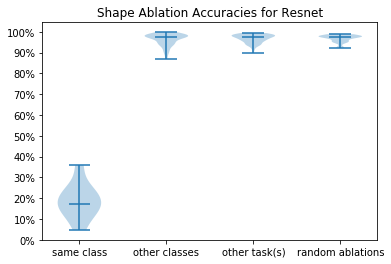

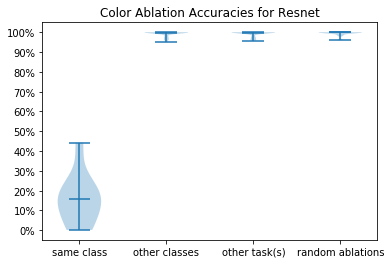

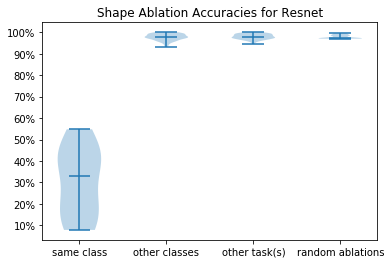

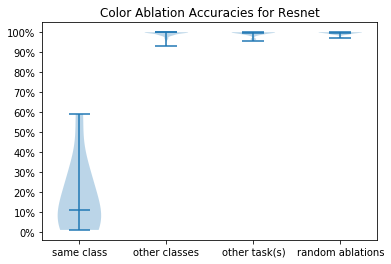

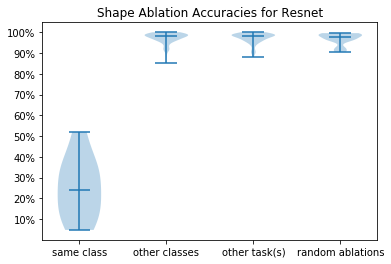

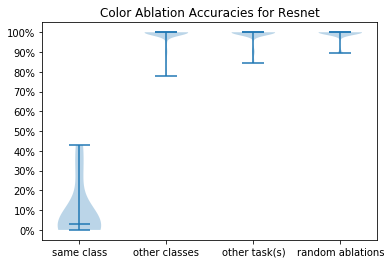

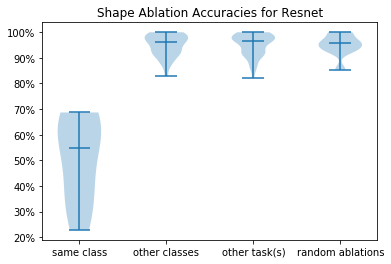

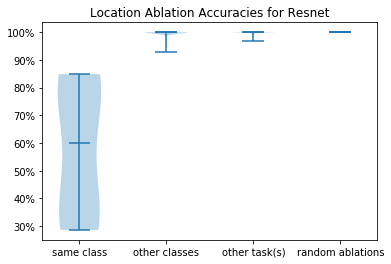

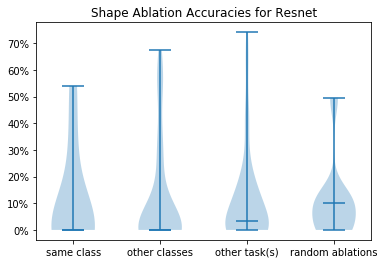

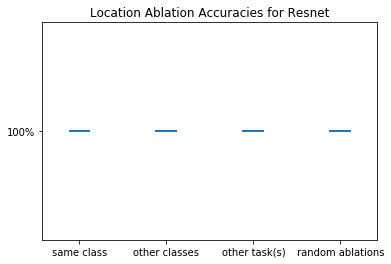





No shape/location ablation accuracy data, or wrong filenames:
['../analysis/resnet/ablation_data/left_out_varied_location_mnist_shape_only/ablate_shape-test_shape.npy', '../analysis/resnet/ablation_data/left_out_varied_location_mnist_shape_only/ablate_shape-test_location.npy', '../analysis/resnet/ablation_data/left_out_varied_location_mnist_shape_only/ablate_location-test_shape.npy', '../analysis/resnet/ablation_data/left_out_varied_location_mnist_shape_only/ablate_location-test_location.npy', '../analysis/resnet/ablation_data/left_out_varied_location_mnist_shape_only/ablate_random-test_shape.npy', '../analysis/resnet/ablation_data/left_out_varied_location_mnist_shape_only/ablate_random-test_location.npy']






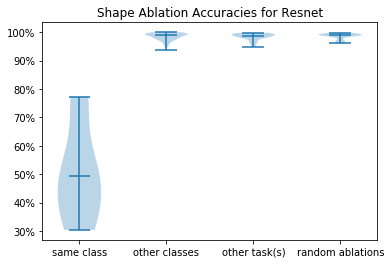

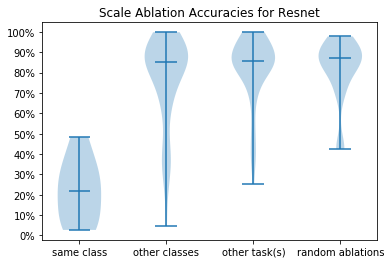

In [20]:
shape_color_names = ["shape","color"]
color_dataset_name = "left_out_colored_mnist"
color_dataset_name_c = "left_out_colored_mnist_color_only"
color_dataset_name_s = "left_out_colored_mnist_shape_only"
num_color_classes = 10


shape_loc_names = ["shape","location"]
loc_dataset_name = "left_out_varied_location_mnist"
loc_dataset_name_l = "left_out_varied_location_mnist_location_only"
loc_dataset_name_s = "left_out_varied_location_mnist_shape_only"
num_loc_classes = 9

shape_scale_names = ["shape","scale"]
scale_dataset_name = "left_out_many_scale_mnist"
num_scale_classes = 9

#shape_color
plot_ablation_accuracies(shape_color_names, model_name, color_dataset_name, num_color_classes,
                        save=save,name="shape-color")
print("\n\n\n")

plot_ablation_accuracies(shape_color_names, model_name, color_dataset_name_c, num_color_classes,
                        save = save, name="shape-color-color_only")
print("\n\n\n")

plot_ablation_accuracies(shape_color_names, model_name, color_dataset_name_s, num_color_classes,
                        save = save, name="shape-color-shape_only")
print("\n\n\n")

plot_ablation_accuracies(shape_loc_names, model_name, loc_dataset_name, num_loc_classes,
                        save=save,name="shape-location")
print("\n\n\n")

plot_ablation_accuracies(shape_loc_names, model_name, loc_dataset_name_l, num_loc_classes,
                        save=save,name="shape-location-location_only")
print("\n\n\n")

plot_ablation_accuracies(shape_loc_names, model_name, loc_dataset_name_s, num_loc_classes,
                        save=save,name="shape-location-shape_only")
print("\n\n\n")

plot_ablation_accuracies(shape_scale_names, model_name, scale_dataset_name, num_scale_classes,
                        save=save,name="shape-scale")



In [44]:
noise = True
data_dict = {}
full_data_dict = {}
for l in ["","_layer1","_layer3"]:
    full_data_dict[l] = {}

klist = [10,20,30,40,50,60,70,80,90]
if dataset_name != "left_out_colored_mnist":
    klist = [11,22,33,44,55,66,77,88]
    
for keep in klist:
    #model_name = 'resnet'
    #model_name = 'resnet_pretrained_embeddings'
    #model_name = 'resnet_no_pool'
    #model_name = 'simple_cnn'
    path = '../analysis/' + model_name + '/invariance_data/' + dataset_name+'/'
    
    file_final = path + model_name +'_'+dataset_name+"_keep"+str(keep) + '.npy'
    file_layer1 = path + model_name +'_'+dataset_name+"_keep"+str(keep)+ '_layer1.npy'
    file_layer3 = path + model_name +'_'+dataset_name+"_keep"+str(keep)+  '_layer3.npy'
        
    file = file_final
    if layer =="_layer1":
        file = file_layer1
    elif layer =="_layer3":
        file = file_layer3

    if model_name == 'resnet':
        dat_final = np.load(file_final)
        dat_layer1 = np.load(file_layer1)
        dat_layer3 = np.load(file_layer3)
        full_data_dict[""][keep] = dat_final
        full_data_dict['_layer1'][keep] = dat_layer1
        full_data_dict['_layer3'][keep] = dat_layer3
        
    #file = '../analysis/processed_array20.npy'
    #(2, 10, N, 10 32,32,3)
    #type, shape class, num_examples, color class, RGB img
    data_dict[keep] = np.load(file)
 

#print(data_dict[90].shape)
print(percentile_theshold)
print(percentile_array.shape)
print(num_neurons)
invariance_thres_array = np.reshape(percentile_array,(1,1,1,1,num_neurons))
invariance_thres_array = np.tile(invariance_thres_array,[2,10,10,10,1])
print(invariance_thres_array.shape)


10
(1, 512)
512
(2, 10, 10, 10, 512)


(2, 10, 512)
(2, 10, 512)
(2, 10, 512)
(2, 10, 512)
(2, 10, 512)
(2, 10, 512)
(2, 10, 512)
(2, 10, 512)
(2, 10, 512)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


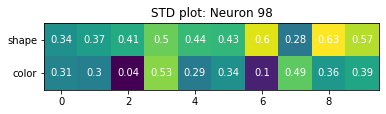

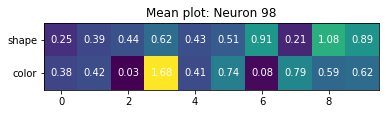

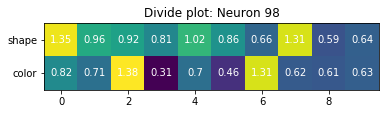

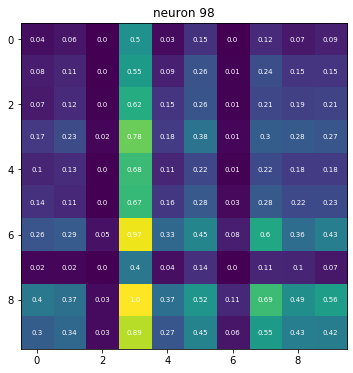

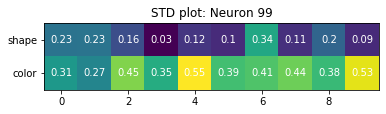

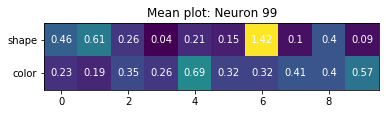

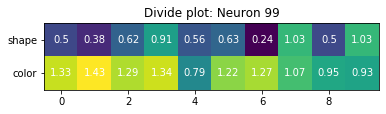

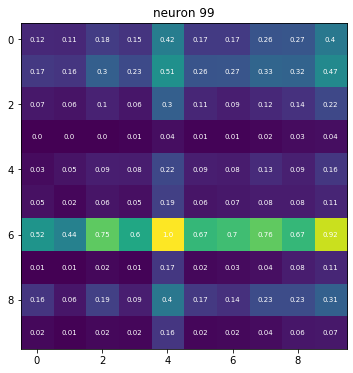

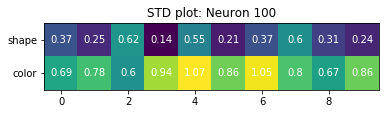

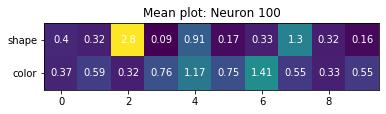

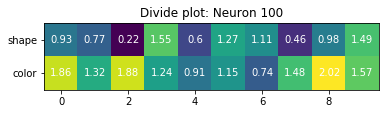

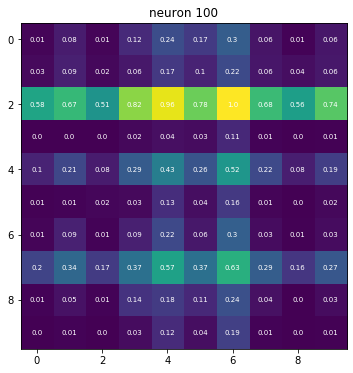

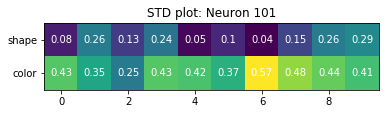

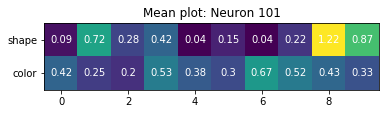

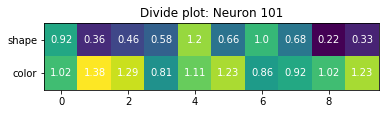

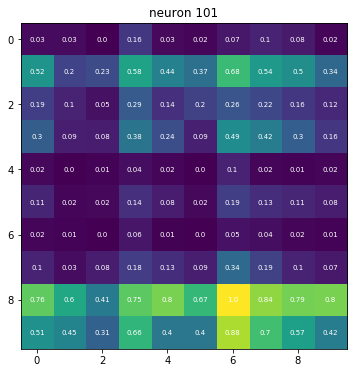

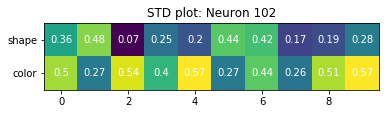

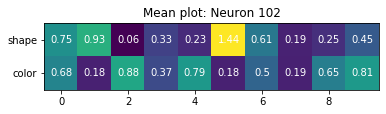

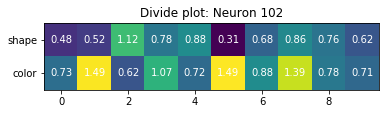

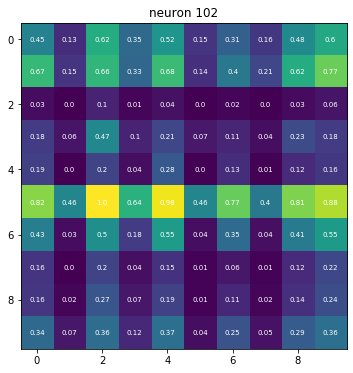

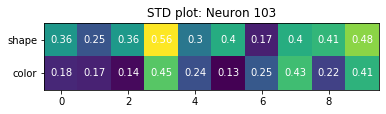

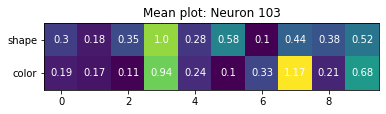

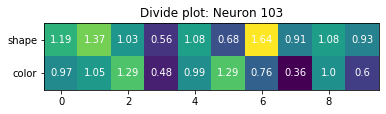

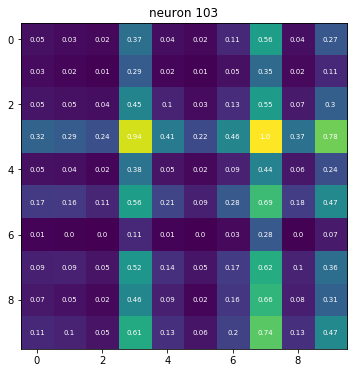

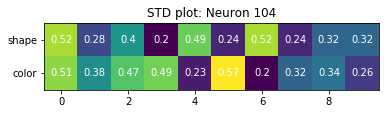

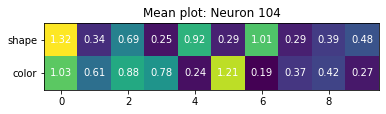

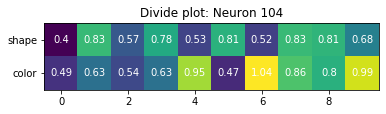

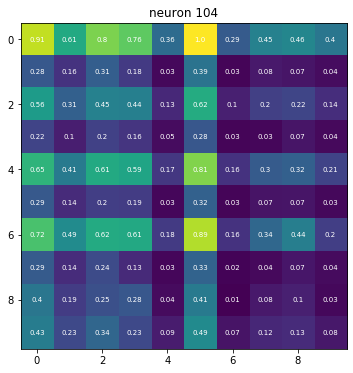

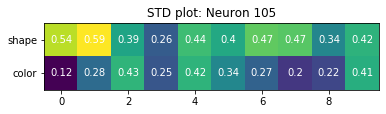

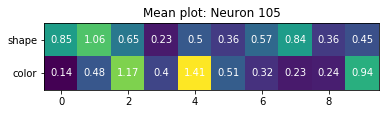

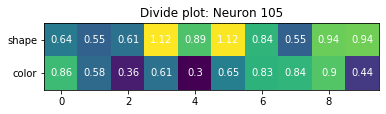

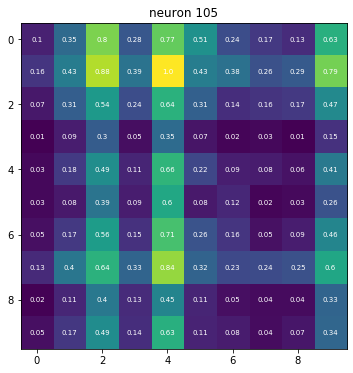

In [45]:

full_tables_mean_dict = {"":{},"_layer1":{},"_layer3":{}}
full_tables_std_dict = {"":{},"_layer1":{},"_layer3":{}}
full_tables_divide_dict = {"":{},"_layer1":{},"_layer3":{}}

tables_mean_dict = {}
tables_std_dict = {}
tables_divide_dict = {}
for keep_pct in klist:
    data = data_dict[keep_pct]
    
    data_final_layer,data_layer1,data_layer3 = None,None,None
    if model_name == 'resnet':
        data_final_layer = full_data_dict[''][keep_pct]
        data_layer1 = full_data_dict['_layer1'][keep_pct]
        data_layer3 = full_data_dict['_layer3'][keep_pct]
    '''
    if use_thresholding:
        data = (data >= invariance_thres_array).astype(float)
    '''
    tables_mean = np.mean(data, axis=3)
    tables_mean = np.mean(tables_mean, axis=2)
    
    if model_name == 'resnet':
        tables_mean_final = np.mean(data_final_layer,axis=3)
        tables_mean_final = np.mean(tables_mean_final,axis=2)
        tables_mean_layer1 = np.mean(data_layer1,axis=3)
        tables_mean_layer1 = np.mean(tables_mean_layer1,axis=2)
        tables_mean_layer3 = np.mean(data_layer3,axis=3)
        tables_mean_layer3 = np.mean(tables_mean_layer3,axis=2)
    
    
    
    print(tables_mean.shape)
    if model_name == 'simple_cnn':
        num_neurons = 500
    else:
        if layer =="_layer1":
            num_neurons = 64
        elif layer == "_layer3":
            num_neurons = 256
        else:
            num_neurons = 512

    tables_std = np.std(data, axis=3)
    tables_std = np.mean(tables_std, axis=2)
    
    if model_name == 'resnet':
        tables_std_final = np.std(data_final_layer,axis=3)
        tables_std_final = np.mean(tables_std_final,axis=2)
        tables_std_layer1 = np.std(data_layer1,axis=3)
        tables_std_layer1 = np.mean(tables_std_layer1,axis=2)
        tables_std_layer3 = np.std(data_layer3,axis=3)
        tables_std_layer3 = np.mean(tables_std_layer3,axis=2)
    

    tables_divide = np.divide(tables_std, tables_mean)
    
    if model_name == 'resnet':
        tables_divide_final = np.divide(tables_std_final,tables_mean_final)
        tables_divide_layer1 = np.divide(tables_std_layer1,tables_mean_layer1)
        tables_divide_layer3 = np.divide(tables_std_layer3,tables_mean_layer3)
    
    #tables_divide[tables_divide == np.inf] = 0
    tables_mean_dict[keep_pct] = tables_mean
    tables_std_dict[keep_pct] = tables_std
    tables_divide_dict[keep_pct] = tables_divide
    
    if model_name == 'resnet': 
        tables_dat=[tables_mean_final, tables_mean_layer1, tables_mean_layer3,
                   tables_std_final,  tables_std_layer1,  tables_std_layer3,
                   tables_divide_final,tables_divide_layer1,tables_divide_layer3]
    
        for k in range(3):
            l = ["","_layer1","_layer3"][k]
            full_tables_mean_dict[l][keep_pct] = tables_dat[k]
            full_tables_std_dict[l][keep_pct] = tables_dat[k+3]
            full_tables_divide_dict[l][keep_pct] = tables_dat[k+6]
            
        
        

data_mean = np.mean(data, axis=2)
neuron_combinations_mat0 = np.zeros((num_neurons, num_classes, num_classes))
neuron_combinations_mat1 = np.zeros((num_neurons, num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        neuron_combinations_mat0[:,i,j] = copy.deepcopy(data_mean[0][i][j])
        neuron_combinations_mat1[:,i,j] = copy.deepcopy(data_mean[1][i][j])
        
neuron_range = [individual_neuron_plots_start_index,individual_neuron_plots_end_index]


for i in range(neuron_range[0], neuron_range[1]):
    #print(tables[:,:,i])
    
    
    fig, ax = plt.subplots()
    plt.title("STD plot: Neuron " + str(i))
     
    for j in range(2):
        for k in range(num_classes):
            out = round(tables_std[:,:,i][j][k],2)
            if out > 1:
                out = round(out,2)
            text = ax.text(k,j, out, color='w', size=10,
                          ha = 'center', va='center')
            
    plt.imshow(tables_std[:,:,i])
    plt.yticks([0,1],['shape','color'])
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Mean plot: Neuron " + str(i))
    
    for j in range(2):
        for k in range(num_classes):
            out = round(tables_mean[:,:,i][j][k],2)
            if out > 1:
                out = round(out,2)
            text = ax.text(k,j, out, color='w', size=10,
                           ha = 'center', va='center')
            
    plt.imshow(tables_mean[:,:,i])
    plt.yticks([0,1],['shape','color'])
    plt.show()
    
    
    fig, ax = plt.subplots()
    plt.title("Divide plot: Neuron " + str(i))
    
    for j in range(2):
        for k in range(num_classes):
            out = round(tables_divide[:,:,i][j][k],2)
            if out > 1:
                out = round(out,2)
            text = ax.text(k,j, out, color='w', size=10,
                          ha = 'center', va='center')
    
    
    plt.imshow(tables_divide[:,:,i])
    plt.yticks([0,1],['shape','color'])
    plt.show()
    
    
    
    plot_combination_acts(neuron_combinations_mat0, i,i+1)
    #plot_combination_acts(neuron_combinations_mat1, i)

    
    
    


(2, 10, 512)



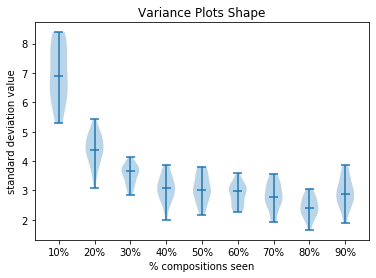



---------------------------------------------


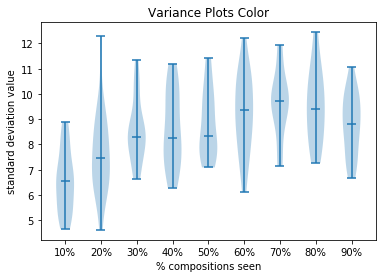

In [47]:
var_path = plot_path + "/variance_plots/"
if not os.path.exists(var_path):
    os.makedirs(var_path)

print(tables_divide.shape)
invariance1 = []
invariance2 = []
n = 20

showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema

def get_nth_smallest(array, leave_out, n_list, first_idx=0, place=0):
    par_list = []
    for i in range(num_classes):
        if i in leave_out:
            continue
        par_list.append(array[first_idx,i,n_list])
    par_list = np.array(par_list)
    return np.partition(par_list,place,axis=0)[place]
    
    
for idx,k in enumerate(klist):
    table = copy.deepcopy(tables_divide_dict[k])
    table[np.isnan(table)] = 0
    for c1 in range(num_classes):
        first_index = 0
        ordered_neurons = np.argsort(selectivity_dicts[layer]['task1_individual'][k][c1])#selectivity_task1[c1][k])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        neurons_array = ordered_neurons[:n]
        class_inv = copy.deepcopy(table[first_index,c1,neurons_array])
        second_inv = get_nth_smallest(copy.deepcopy(table), [c1], neurons_array)
        third_inv = get_nth_smallest(copy.deepcopy(table), [c1], neurons_array, place=2)
        fifth_inv = get_nth_smallest(copy.deepcopy(table), [c1], neurons_array, place=4)
        #invariance1 += [class_inv,second_inv,third_inv,fifth_inv]
        if len(invariance1) == idx:
            invariance1.append(class_inv) #= [class_inv,second_inv,third_inv,fifth_inv]
        else:
            invariance1[idx] += class_inv
            #invariance1[1] += second_inv
            #invariance1[2] += third_inv
            #invariance1[3] += fifth_inv
#invariance1 = np.reshape(invariance1,(-1,4))
for idx,k in enumerate(klist):   
    table = copy.deepcopy(tables_divide_dict[k])
    table[np.isnan(table)] = 0
    for c2 in range(num_classes):
        first_index = 1
        ordered_neurons = np.argsort(selectivity_dicts[layer]['task2_individual'][keep][c2])#selectivity_task2[c2][keep])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        neurons_array = ordered_neurons[:n]
        class_inv = copy.deepcopy(table[first_index,c1,neurons_array])
        second_inv = get_nth_smallest(copy.deepcopy(table), [c2], neurons_array, first_idx=first_index)
        third_inv = get_nth_smallest(copy.deepcopy(table), [c2], neurons_array, first_idx=first_index, place=2)
        fifth_inv = get_nth_smallest(copy.deepcopy(table), [c2], neurons_array, first_idx=first_index, place=4)
        #invariance2 += [class_inv,second_inv,third_inv,fifth_inv]
        if len(invariance2) == idx:
            invariance2.append(class_inv) #= [class_inv,second_inv,third_inv,fifth_inv]
        else:
            invariance2[idx] += class_inv
            #invariance2[1] += second_inv
            #invariance2[2] += third_inv
            #invariance2[3] += fifth_inv


print("")
#for i in range(10):
fig, ax = plt.subplots()
ax.set_title("Variance Plots "+ make_first_upper(short_names['task1']))
ax.set_xticks([i+1 for i in range(len(klist))])
ax.set_xticklabels([str(i)+"%" for i in klist])
ax.set_ylabel("standard deviation value")
ax.set_xlabel("% compositions seen")
plt.violinplot(invariance1, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(var_path + "resnet_variance_"+short_names['task1']+".pdf")
plt.show()
    
print("\n\n---------------------------------------------")
#for j in range(10):
fig, ax = plt.subplots()
ax.set_title("Variance Plots "+make_first_upper(short_names['task2']))
ax.set_xticks([i+1 for i in range(len(klist))])
ax.set_xticklabels([str(i)+"%" for i in klist])
ax.set_ylabel("standard deviation value")
ax.set_xlabel("% compositions seen")
plt.violinplot(invariance2, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(var_path + "resnet_variance_"+short_names['task2']+".pdf")
plt.show()

    
    

In [67]:

full_invariance1 = []
full_invariance2 = []
n = 20

if klist[0] != 11:
    keep_to_plot = 90
else:
    keep_to_plot = 88

showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema

for idx,k in enumerate(['_layer1','_layer3','']):
    table = copy.deepcopy(full_tables_divide_dict[k][keep_to_plot])
    table[np.isnan(table)] = -1
    for c1 in range(num_classes):
        first_index = 0
        ordered_neurons = np.argsort(selectivity_dicts[k]['task1_individual'][keep_to_plot][c1])
        #ordered_neurons = np.argsort(selectivity_task1[c1][k])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        neurons_array = ordered_neurons[:n]
        class_inv = copy.deepcopy(table[first_index,c1,neurons_array])
        
        if len(full_invariance1) == idx:
            full_invariance1.append(class_inv)
        else:
            full_invariance1[idx] += class_inv
           
        
for idx,k in enumerate(['_layer1','_layer3','']):   
    table = copy.deepcopy(full_tables_divide_dict[k][keep_to_plot])
    table[np.isnan(table)] = 10
    for c2 in range(num_classes):
        first_index = 1
        ordered_neurons = np.argsort(selectivity_dicts[k]['task2_individual'][keep_to_plot][c2])
        #ordered_neurons = np.argsort(selectivity_task2[c2][keep])
        ordered_neurons = np.flip(ordered_neurons, axis=0)
        neurons_array = ordered_neurons[:n]
        class_inv = copy.deepcopy(table[first_index,c1,neurons_array])
        
        if len(full_invariance2) == idx:
            full_invariance2.append(class_inv) 
        else:
            full_invariance2[idx] += class_inv
            

print("")
#for i in range(10):
fig, ax = plt.subplots()
ax.set_title("Variance Plots "+short_names['task1'])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['layer 1','layer 3','final layer'])
ax.set_ylabel("standard deviation value")
ax.set_xlabel("layer")
plt.violinplot(full_invariance1, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(var_path + "resnet_variance_per_layer_"+short_names['task1']+".pdf")
plt.show()
    
print("\n\n---------------------------------------------")
#for j in range(10):
fig, ax = plt.subplots()
ax.set_title("Variance Plots "+short_names['task2'])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['layer 1','layer 3','final layer'])
ax.set_ylabel("standard deviation value")
ax.set_xlabel("layer")
plt.violinplot(full_invariance2, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
if save:
    plt.savefig(var_path + "resnet_variance_per_layer"+short_names['task2']+".pdf")
plt.show()






KeyError: 90